Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [3]:
NAME = "Weronika Pawlak"

---

# Loopy Belief Propagation

Ta lista zadań dotyczy algorytmów propagacji wiary (ang. belief propagation), które zostały Państwu przedstawione na wykładzie. W tej rodzinie metod identyfikujemy dwa rodzaje algorytmów:
- Belief Propagation służący do dokładnego wnioskowania dla modeli o drzewiastej strukturze. Jest to dokładna metoda, nie posiada zatem różnych wersji.
- Loopy Belief Propagation służace do przybliżonego wnioskowania dla modeli zawierających cykle. Posiada wiele wersji. Kilka z nich omówimy, zaimplementujemy i przebadamy eksperymentalnie na tej liście zadań.

Ponownie skupimy się na sytuacji gdy wszystkie zmienne są dyskretne. Mogą one posiadać różne nośniki, o różnej liczności. Opracowywane implementacje będę potrafiły obsłużyć dowolną sytuację. W części eksperymentalnej ograniczym się do sytuacji, gdy wszystkie zmienne są binarne.

W tej liście zakładamy, że znają i rozumieją Państwo algorytm Belief Propagation oraz Loopy Belief Propagation w bazowej wersji, których implementacje zostały dla Państwa przygotowane. Jeżeli tak nie jest, to będą mieli Państwo poznać te algorytmy przez prześledzenie ich implementacji - zdaniem autora listy jest to najszybsza i najskuteczniejsza droga.

Zadania na tej liście będą polegały na rozszerzeniu algorytmu Loopy Belief Propagation tak by spełniał swoją rolę dla większego spektrum modeli. Były one zainspirowane przez *Murphy, K. P. (n.d.). Machine Learning: A Probabilistic Perspective. Chapter 22.2.4 Loopy beliefpropagation: algorithmic issues - Convergence
LBP*, który powstał w większości na bazie *Koller, D., & Friedman, N. (2015). Probabilistic graphical models. In Studies in Systems, Decision and Control (Vol. 11). https://doi.org/10.1007/978-3-319-11325-8_2 Box 11.B — Skill: Making loopy belief propagation work in practice*.

Bazowe implementacje struktur danych, operacji na nich oraz algorytmów Belief Propagation i Loopy Belief Propagation pochodzą z następującego źródła - https://github.com/krashkov/Belief-Propagation

In [4]:
import numpy as np
import igraph as ig
from networkx.algorithms.cycles import find_cycle
from networkx.exception import NetworkXNoCycle
import pyvis.network as net
from pprint import pprint
from collections import defaultdict
from matplotlib import pyplot as plt
from operator import itemgetter
from itertools import chain
from copy import copy

C:\Users\User\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\User\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


# Struktura danych Factor (czynnik)

In [5]:
class factor:
    def __init__(self, variables = None, distribution = None):
        if (distribution is None) and (variables is not None):
            self._set_data(np.array(variables), None, None)
        elif (variables is None) or (len(variables) != len(distribution.shape)):
            raise Exception('Data is incorrect')
        else:
            self._set_data(np.array(variables),
                            np.array(distribution),
                            np.array(distribution.shape))
    
    def _set_data(self, variables, distribution, shape):
        self._variables    = variables
        self._distribution = distribution
        self._shape        = shape
    
    # ----------------------- Info --------------------------
    def is_none(self):
        return True if self._distribution is None else False
        
    # ----------------------- Getters -----------------------
    def get_variables(self):
        return self._variables
    
    def get_distribution(self):
        return self._distribution
    
    def get_shape(self):
        return self._shape

## Operacje na czynnikach

### Iloczyn dwóch czynników

In [6]:
def factor_product(x, y):
    if x.is_none() or y.is_none():
        raise Exception('One of the factors is None')
    
    xy, xy_in_x_ind, xy_in_y_ind = np.intersect1d(x.get_variables(), y.get_variables(), return_indices=True)
    
    if xy.size == 0:
        raise Exception('Factors do not have common variables')
    
    if not np.all(x.get_shape()[xy_in_x_ind] == y.get_shape()[xy_in_y_ind]):
        raise Exception('Common variables have different order')
    
    x_not_in_y = np.setdiff1d(x.get_variables(), y.get_variables(), assume_unique=True)
    y_not_in_x = np.setdiff1d(y.get_variables(), x.get_variables(), assume_unique=True)
    
    x_mask = np.isin(x.get_variables(), xy, invert=True)
    y_mask = np.isin(y.get_variables(), xy, invert=True)
    
    x_ind = np.array([-1]*len(x.get_variables()), dtype=int)
    y_ind = np.array([-1]*len(y.get_variables()), dtype=int)
    
    x_ind[x_mask] = np.arange(np.sum(x_mask))
    y_ind[y_mask] = np.arange(np.sum(y_mask)) + np.sum(np.invert(y_mask))
    
    x_ind[xy_in_x_ind] = np.arange(len(xy)) + np.sum(x_mask)
    y_ind[xy_in_y_ind] = np.arange(len(xy))
    
    x_distribution = np.moveaxis(x.get_distribution(), range(len(x_ind)), x_ind)
    y_distribution = np.moveaxis(y.get_distribution(), range(len(y_ind)), y_ind)
                
    res_distribution =   x_distribution[tuple([slice(None)]*len(x.get_variables())+[None]*len(y_not_in_x))] \
                       * y_distribution[tuple([None]*len(x_not_in_y)+[slice(None)])]
    
    return factor(list(x_not_in_y)+list(xy)+list(y_not_in_x), res_distribution)

### Rozkład brzegowy na podstawie czynnika

In [7]:
def factor_marginalization(x, variables):
    variables = np.array(variables)
    
    if x.is_none():
        raise Exception('Factor is None')
    
    if not np.all(np.in1d(variables, x.get_variables())):
        raise Exception('Factor do not contain given variables')
    
    res_variables    = np.setdiff1d(x.get_variables(), variables, assume_unique=True)
    res_distribution = np.sum(x.get_distribution(),
                              tuple(np.where(np.isin(x.get_variables(), variables))[0]))
    
    return factor(res_variables, res_distribution)

### Redukcja czynnika poprzez wprowadzenie obserwacji

In [8]:
def factor_reduction(x, variable, value):
    if x.is_none() or (variable is None) or (value is None):
        raise Exception('Input is None')
    
    if not np.any(variable == x.get_variables()):
        raise Exception('Factor do not contain given variable')
    
    if value >= x.get_shape()[np.where(variable==x.get_variables())[0]]:
        raise Exception('Incorrect value of given variable')
    
    res_variables    = np.setdiff1d(x.get_variables(), variable, assume_unique=True)
    res_distribution = np.take(x.get_distribution(),
                               value,
                               int(np.where(variable==x.get_variables())[0]))
    
    return factor(res_variables, res_distribution)

## Rozkład łączny modelu złożonego z czynników

In [9]:
def joint_distribution(ar):
    for element in ar:
        if element.is_none():
            raise Exception('Factor is None')
    
    res = ar[0]
    for element in ar[1:]:
        res = factor_product(res, element)
    
    return res

# Structura danych Factor Graph
W tej implementacji wykorzystano bibliotekę [igraph](https://igraph.org/) do przechowywania grafu oraz wykonywania na nim operacji. Równoważna implementacja może powstać na bazie biblioteki `networkx` dotychczas wykorzystywanej na tym kursie.

In [10]:
class FactorGraph:
    def __init__(self):
        self._graph = ig.Graph()
    
    # ----------------------- Factor node functions ---------
    def add_factor_node(self, f_name, factor_):
        if (self.get_node_status(f_name) != False) or (f_name in factor_.get_variables()):
            raise Exception('Invalid factor name')
        if type(factor_) is not factor:
            raise Exception('Invalid factor_')
        for v_name in factor_.get_variables():
            if self.get_node_status(v_name) == 'factor':
                raise Exception('Invalid factor')

        # Check ranks
        self._check_variable_ranks(f_name, factor_, 1)
        # Create variables
        for v_name in factor_.get_variables():
            if self.get_node_status(v_name) == False:
                self._create_variable_node(v_name)
        # Set ranks
        self._set_variable_ranks(f_name, factor_)
        # Add node and corresponding edges
        self._create_factor_node(f_name, factor_)

    def change_factor_distribution(self, f_name, factor_):
        if self.get_node_status(f_name) != 'factor':
            raise Exception('Invalid variable name')
        if set(factor_.get_variables()) != set(self._graph.vs[self._graph.neighbors(f_name)]['name']):
            raise Exception('invalid factor distribution')

        # Check ranks
        self._check_variable_ranks(f_name, factor_, 0)
        # Set ranks
        self._set_variable_ranks(f_name, factor_)
        # Set data
        self._graph.vs.find(name=f_name)['factor_'] = factor_

    def remove_factor(self, f_name, remove_zero_degree=False):
        if self.get_node_status(f_name) != 'factor':
            raise Exception('Invalid variable name')

        neighbors = self._graph.neighbors(f_name, mode="out")
        self._graph.delete_vertices(f_name)

        if remove_zero_degree:
            for v_name in neighbors:
                if self._graph.vs.find(v_name).degree() == 0:
                    self.remove_variable(v_name)

    def _create_factor_node(self, f_name, factor_):
        # Create node
        self._graph.add_vertex(f_name)
        self._graph.vs.find(name=f_name)['is_factor'] = True
        self._graph.vs.find(name=f_name)['factor_']   = factor_

        # Create corresponding edges
        start = self._graph.vs.find(name=f_name).index
        edge_list = [tuple([start, self._graph.vs.find(name=i).index]) for i in factor_.get_variables()]
        self._graph.add_edges(edge_list)
    
    # ----------------------- Rank functions -------
    def _check_variable_ranks(self, f_name, factor_, allowded_v_degree):
        for counter, v_name in enumerate(factor_.get_variables()):
            if (self.get_node_status(v_name) == 'variable') and (not factor_.is_none()):
                if     (self._graph.vs.find(name=v_name)['rank'] != factor_.get_shape()[counter]) \
                   and (self._graph.vs.find(name=v_name)['rank'] != None) \
                   and (self._graph.vs.find(v_name).degree() > allowded_v_degree):
                    raise Exception('Invalid shape of factor_')

    def _set_variable_ranks(self, f_name, factor_):
        for counter, v_name in enumerate(factor_.get_variables()):
            if factor_.is_none():
                self._graph.vs.find(name=v_name)['rank'] = None
            else:
                self._graph.vs.find(name=v_name)['rank'] = factor_.get_shape()[counter]
        
    # ----------------------- Variable node functions -------
    def add_variable_node(self, v_name):
        if self.get_node_status(v_name) != False:
            raise Exception('Node already exists')
        self._create_variable_node(v_name)

    def remove_variable(self, v_name):
        if self.get_node_status(v_name) != 'variable':
            raise Exception('Invalid variable name')
        if self._graph.vs.find(v_name).degree() != 0:
            raise Exception('Can not delete variables with degree >0')
        self._graph.delete_vertices(self._graph.vs.find(v_name).index)   

    def _create_variable_node(self, v_name, rank=None):
        self._graph.add_vertex(v_name)
        self._graph.vs.find(name=v_name)['is_factor'] = False
        self._graph.vs.find(name=v_name)['rank'] = rank

    # ----------------------- Info --------------------------
    def get_node_status(self, name):
        if len(self._graph.vs) == 0:
            return False
        elif len(self._graph.vs.select(name_eq=name)) == 0:
            return False
        else:
            if self._graph.vs.find(name=name)['is_factor'] == True:
                return 'factor'
            else:
                return 'variable'
            
    def get_factors(self, distribution=False):
        return {
            node['name']: node['factor_'].get_distribution() if distribution else node['factor_']
            for node in self._graph.vs if node['is_factor'] == True
        }
    
    def get_variables(self):
        return [
            node['name']
            for node in self._graph.vs if node['is_factor'] == False
        ]
    
    # ----------------------- Graph structure ---------------
    def get_graph(self):
        return self._graph

    def is_connected(self):
        return self._graph.is_connected()
    
    def has_cycle(self):
        try:
            find_cycle(self._graph.to_networkx())
            return True
        except NetworkXNoCycle:
            return False

# Tworzenie modelu na podstawie wzoru

In [11]:
def string2factor_graph(str_):
    res_factor_graph = FactorGraph()
    
    str_ = [i.split('(') for i in str_.split(')') if i != '']
    for i in range(len(str_)):
        str_[i][1] = str_[i][1].split(',')
        
    for i in str_:
        res_factor_graph.add_factor_node(i[0], factor(i[1]))
    
    return res_factor_graph

Przykład użycia:

In [12]:
pgm = string2factor_graph('phi_1(a,b,c)phi_2(b,c,d,e)psi_3(e,c)psi_4(d)')

# Tworzenie interaktywnych wykresów
Wykorzystanie interaktywnej biblioteki do wizualizacji modelu umożliwia odczytanie potencjału znajdującego się w czynniku po najechaniu na niego kursorem. Aby wyświetlić potencjały muszą być one uprzednio przypisane do czynników.

In [13]:
def plot_factor_graph(x, filename):
    graph = net.Network(notebook=True, width="100%")
    graph.barnes_hut()
    graph.toggle_physics(False)
    
    # Vertices
    label = x.get_graph().vs['name']
    color = ['#2E2E2E' if i is True else '#F2F2F2' for i in x.get_graph().vs['is_factor']]
    shape = ['square' if i is True else 'dot' for i in x.get_graph().vs['is_factor']]
    for node in range(len(x.get_graph().vs)):
        if shape[node] == 'dot':
            graph.add_node(node, label=label[node], color=color[node], shape=shape[node])
        else:
            title=x.get_graph().vs.find(name=label[node])['factor_'].get_distribution()
            if title is not None:
                title=np.array2string(title)
            graph.add_node(node, label=label[node], color=color[node], shape=shape[node], title=title)
    
    # Edges
    graph.add_edges(x.get_graph().get_edgelist())
    
    return graph.show(f'./{filename}.html')

Przykład użycia:

In [14]:
plot_factor_graph(pgm, 'example')

# Implementacja algorytmu Belief Propagation
Aby uniknąć problemów numerycznych (overflow) każda wiadomość jest normalizowana przed wysłaniem.

In [15]:
class BeliefPropagation():
    def __init__(self, pgm):
        if type(pgm) is not FactorGraph:
            raise Exception('PGM is not a factor graph')
        if not (pgm.is_connected() and not pgm.has_cycle()):
            raise Exception('PGM is not a (poly)tree')
        
        self._msg = {}
        self._pgm = pgm
    
    def belief(self, v_name):
        incoming_messages = []
        for f_name_neighbor in self._pgm.get_graph().vs[self._pgm.get_graph().neighbors(v_name)]['name']:
            incoming_messages.append(self.get_factor2variable_msg(f_name_neighbor, v_name))
        return self._normalize_msg(joint_distribution(incoming_messages))
    
    # ----------------------- Variable to factor ------------
    def get_variable2factor_msg(self, v_name, f_name):
        key = (v_name, f_name)
        if key not in self._msg:
            self._msg[key] = self._compute_variable2factor_msg(v_name, f_name)
        return self._msg[key]
    
    def _compute_variable2factor_msg(self, v_name, f_name):
        incoming_messages = []
        for f_name_neighbor in self._pgm.get_graph().vs[self._pgm.get_graph().neighbors(v_name)]['name']:
            if f_name_neighbor != f_name:
                incoming_messages.append(self.get_factor2variable_msg(f_name_neighbor, v_name))
        
        if not incoming_messages:
            # if the variable does not have its own distribution
            return factor([v_name], np.array([1.]*self._pgm.get_graph().vs.find(name=v_name)['rank']))
        else:
            # Since all messages have the same dimension (1, order of v_name) the expression after
            # ```return``` is equivalent to ```factor(v_name, np.prod(incoming_messages))```
            return self._normalize_msg(joint_distribution(incoming_messages))
    
    # ----------------------- Factor to variable ------------
    def get_factor2variable_msg(self, f_name, v_name):
        key = (f_name, v_name)
        if key not in self._msg:
            self._msg[key] = self._compute_factor2variable_msg(f_name, v_name)
        return self._msg[key]
    
    def _compute_factor2variable_msg(self, f_name, v_name):
        incoming_messages = [self._pgm.get_graph().vs.find(f_name)['factor_']]
        marginalization_variables = []
        for v_name_neighbor in self._pgm.get_graph().vs[self._pgm.get_graph().neighbors(f_name)]['name']:
            if v_name_neighbor != v_name:
                incoming_messages.append(self.get_variable2factor_msg(v_name_neighbor, f_name))
                marginalization_variables.append(v_name_neighbor)
        return self._normalize_msg(factor_marginalization(
            joint_distribution(incoming_messages),
            marginalization_variables
        ))
    
    # ----------------------- Other -------------------------
    def _normalize_msg(self, message):
        return factor(message.get_variables(), message.get_distribution()/np.sum(message.get_distribution()))

In [16]:
pgm = string2factor_graph('f1(a,b)f2(b,c,d)f3(c)')

plot_factor_graph(pgm, 'example1')

In [17]:
f1 = factor(['a', 'b'],      np.array([[2,3],[6,4]]))
f2 = factor(['b', 'd', 'c'], np.array([[[7,2,3],[1,5,2]],[[8,3,9],[6,4,2]]]))
f3 = factor(['c'],           np.array([5, 1, 9]))

pgm.change_factor_distribution('f1', f1)
pgm.change_factor_distribution('f2', f2)
pgm.change_factor_distribution('f3', f3)

bp = BeliefPropagation(pgm)

pgm_joint_dist = joint_distribution(list(pgm.get_factors().values()))

print('variable, joint marginalization, BP')
for variable in pgm.get_variables():
    dist = factor_marginalization(
        pgm_joint_dist,
        [v for v in pgm.get_variables() if v != variable]
    ).get_distribution()
    print(variable, dist / dist.sum(), bp.belief(variable).get_distribution())

variable, joint marginalization, BP
a [0.36178862 0.63821138] [0.36178862 0.63821138]
b [0.37398374 0.62601626] [0.37398374 0.62601626]
c [0.41158537 0.05335366 0.53506098] [0.41158537 0.05335366 0.53506098]
d [0.70121951 0.29878049] [0.70121951 0.29878049]


# Ising Grid
Ising Grid to probabilistyczy model będącym rozszerzeniem "płaskiego" modelu Isinga do dwóch wymiarów. W ten sposób zmienne w modelu tworzą siatkę, na przykład o boku $N$ zatem składającą się z $N^2$ zmiennych (siatka może mieć też nierówną liczbę zmiennych na krawędziach) binarnych. Taka konstrukcja modelu powoduje, że występują w nim wyłącznie potencjały na jednej zmiennej oraz na parze zmiennych. Tradycyjnie przyjmuje się, że zmienne przyjmują wartości $-1$ oraz $1$ interpretowane jako spin atomu, identycznie do modelu Isinga.

Ising Grid należy do rodziny *Pairwise Markov Networks*, o których można przeczytać w książce *Koller, D., & Friedman, N. (2015). Probabilistic graphical models*

![image](./figures/ising_grid.png)
Source: Pairwise Markov Networks*, o których można przeczytać w książce *Koller, D., & Friedman, N. (2015). Probabilistic graphical models Fig. 4.A.1

# Implementacja generatora Ising Grid
Aby przeprowadzić eksperymentalną analizę wnioskowania dla modelu Ising Grid musimy najpierw posiadać generator takiego modelu - w rzeczywistości mielibyśmy dane na podstawie, których zbudowalibyśmy model. Jego działanie będzie polegało na wylosowaniu potencjałów dla zmiennych "z brzegu" oraz wszystkich par zmiennych według podanych parametrów.

- Dla potencjałów *univariate* reprezentowanych jako wektor o długości 2 (bo zmienna binarna) wykorzystamy rozkład jednostajny na przedziale $[0, C_u)$, gdzie $C_u$ to parametr generatora, dla obu wartości.

- Dla potencjałów *bivariate* reprezentowanych jako macierz 2x2 (potencjał na parze zmiennych binarnych) wykorzstamy następujący wzór:
$$ \epsilon_{i,j}(x_i, x_j) = -w_{i,j} x_i x_j $$
do obliczenia *funkcji energii* (przypominamy, że potencjał $\psi_{i,j}(x_i, x_j) = \exp (-\epsilon_{i,j}(x_i, x_j))$), gdzie $w_{i,j}$ losujemy rozkładem jednostajnym na przedziale $[-C_b, C_b]$, a $C_b$ jest parametrem generatora.
W tym miejscu warto przypomnieć, że zmienne w modelu przyjmują wartości $-1$ oraz $1$, więc gdy $w > 0$ to spiny będą chciały byc takie same (ferromagnetyzm), a gdy $w < 0$ będa się odpychać (anty-ferromagnetyzm).
Analogiczny model możemy zbudowac dla zmiennych o nośniku $\{0, 1\}$. Nazywa się on *Boltzmann distribution* (wspomniany na wykładzie). Mamy tutaj niezerowe odziaływanie wyłącznie gdy obie zmienne są równe 0. Można pokazać, że te modele są sobie równoważne (ale z inną parametryzacją) - *Koller, D., & Friedman, N. (2015). Probabilistic graphical models: exercise 4.12*.

In [18]:
from numpy.random import default_rng
rng = default_rng(2022)

Im większa różnica pomiędzy potencjałami dla jednej zmiennej, a tymi dla par, tym mniej stabilny będzie model oraz efekt działania LBP na nim. *Koller, D., & Friedman, N. (2015). Probabilistic graphical models* sugeruje dla siatki 11x11 zastosować $C_u=1$ oraz $C_b=11$ w celu pokazania różnić w działaniu różnych wersji LBP. Należy zwrócić uwagę, że dla tak generowanych modelów naiwne implementacje LBP nie pozwalają obliczyć prawidłowo większości rozkładów brzegowych.

In [19]:
def sample_ising_grid(N, C_u=1, C_b=11, ising=True):
    def sample_uni_factor(C):
        return rng.random(2) * C
    def sample_bi_factor(C):
        w = rng.random() * 2 * C - C
        if ising:
            return np.exp(- (- w * np.array([[1, -1], [-1, 1]])))
        else:
            return np.exp(- (- w * np.array([[0, 0], [0, 1]])))

    fg = FactorGraph()
    for i in range(N):
        for j in range(N):
            if i in (0, N-1) or j in (0, N-1):
                fg.add_factor_node(
                    f'f_{i},{j}', 
                    factor([f'x_{i},{j}'], sample_uni_factor(C=C_u))
                )
            if i < N-1:
                fg.add_factor_node(
                    f'f_{i},{j}_{i+1},{j}', 
                    factor([f'x_{i},{j}', f'x_{i+1},{j}'], sample_bi_factor(C=C_b))
                )
            if j < N-1:
                fg.add_factor_node(
                    f'f_{i},{j}_{i},{j+1}', 
                    factor([f'x_{i},{j}', f'x_{i},{j+1}'], sample_bi_factor(C=C_b))
                )
                
    return fg

ising_model = sample_ising_grid(4, C_u=1, C_b=3, ising=True)
plot_factor_graph(ising_model, 'ising_grid')

# Wnioskowanie dokładne dla Ising Grid

### Belief Propagation
Próba wykorzystania Belief Propagation zakończy się niepowodzeniem, ponieważ model posiada pętle, co prowadzi do nieskończonej rekurencji.

In [20]:
bp = BeliefPropagation(ising_model)
for variable in ising_model.get_variables():
    bp.belief(variable).get_distribution()

Exception: PGM is not a (poly)tree

### Marginalizacja rozkładu łącznego
Dla każdego modelu grafowego znamy sposób na obliczenie rozkładu łącznego (tutaj funkcja `joint_distribution`), który następnie można zmarginalizować by otrzymać rozkład brzegowy. Koszt tych operacji rośnie jednak wykładniczo z rozmiarem modelu (zagadnienie zostało omówione na wykładzie). W przypadku zbudowanego powyżej modelu jesteśmy w stanie wykonać obliczenia na własnym komputerze, ale to podejście nie sprawdzi się dla już nieznacznie większych modeli - największy model, który dało się policzyć na 16GB pamięci RAM to siatka 5x5.

In [21]:
ising_model_exact_dist = dict()
ising_model_joint_dist = joint_distribution(list(ising_model.get_factors().values()))
for variable in ising_model.get_variables():
    dist = factor_marginalization(
        ising_model_joint_dist,
        [v for v in ising_model.get_variables() if v != variable]
    ).get_distribution()
    ising_model_exact_dist[variable] = dist / dist.sum()
pprint(ising_model_exact_dist)

{'x_0,0': array([0.71353426, 0.28646574]),
 'x_0,1': array([0.28534992, 0.71465008]),
 'x_0,2': array([0.8852351, 0.1147649]),
 'x_0,3': array([0.10883612, 0.89116388]),
 'x_1,0': array([0.41982383, 0.58017617]),
 'x_1,1': array([0.32333175, 0.67666825]),
 'x_1,2': array([0.99832443, 0.00167557]),
 'x_1,3': array([0.99859223, 0.00140777]),
 'x_2,0': array([0.99006826, 0.00993174]),
 'x_2,1': array([0.11097555, 0.88902445]),
 'x_2,2': array([0.00162819, 0.99837181]),
 'x_2,3': array([2.49537901e-05, 9.99975046e-01]),
 'x_3,0': array([0.00913834, 0.99086166]),
 'x_3,1': array([0.98901047, 0.01098953]),
 'x_3,2': array([0.99780001, 0.00219999]),
 'x_3,3': array([9.99977912e-01, 2.20880108e-05])}


# Implementacja Loopy Belief Propagation - wnioskowanie przybliżone
W przypadku Loopy Belief Propagation wybór metody normalizacji wiadomości ma wpływ na działanie algorytmu. W poniższej implementacji zdecydowano się normalizować wyłącznie wiadomości wychodzące z czynników, ponieważ to podejście dawało najlepsze rezultaty.

In [22]:
class LoopyBeliefPropagation():
    def __init__(self, pgm):
        if type(pgm) is not FactorGraph:
            raise Exception('PGM is not a factor graph')
        if not pgm.is_connected():
            raise Exception('PGM is not connected')
        if len(pgm.get_graph().es) - 1 == len(pgm.get_graph().vs):
            raise Exception('PGM is a tree')
        
        self._t       = 0
        self._msg     = {}
        self._msg_new = {}
        self._pgm     = pgm
        
        # Initialization of messages
        for edge in self._pgm.get_graph().es:
            start_index, end_index = edge.tuple[0], edge.tuple[1]
            start_name, end_name = (
                self._pgm.get_graph().vs[start_index]['name'],
                self._pgm.get_graph().vs[end_index]['name']
            )
            
            if self._pgm.get_graph().vs[start_index]['is_factor']:
                self._msg[(start_name, end_name)] = self._pgm.get_graph().vs[end_index]['factor_']
            else:
                self._msg[(start_name, end_name)] = factor(
                    [start_name],
                    np.array([1.]*self._pgm.get_graph().vs[start_index]['rank'])
                )
            self._msg[(end_name, start_name)] = self._msg[(start_name, end_name)]
            
            self._msg_new[(start_name, end_name)] = 0
            self._msg_new[(end_name, start_name)] = 0
    
    def belief(self, v_name, num_iter):
        if self._t > num_iter:
            raise Exception('Invalid number of iterations. Current number: ' + str(self._t))
        elif self._t < num_iter:
            self._loop(num_iter)
        
        incoming_messages = []
        for f_name_neighbor in self._pgm.get_graph().vs[self._pgm.get_graph().neighbors(v_name)]['name']:
            incoming_messages.append(self.get_factor2variable_msg(f_name_neighbor, v_name))
        return self._normalize_msg(joint_distribution(incoming_messages))
    
    # ----------------------- Variable to factor ------------
    def get_variable2factor_msg(self, v_name, f_name):
        return self._msg[(v_name, f_name)]
    
    def _compute_variable2factor_msg(self, v_name, f_name):
        incoming_messages = []
        for f_name_neighbor in self._pgm.get_graph().vs[self._pgm.get_graph().neighbors(v_name)]['name']:
            if f_name_neighbor != f_name:
                incoming_messages.append(self.get_factor2variable_msg(f_name_neighbor, v_name))
        
        if not incoming_messages:
            return factor([v_name], np.array([1]*self._pgm.get_graph().vs.find(name=v_name)['rank']))
        else:
            return joint_distribution(incoming_messages)
    
    # ----------------------- Factor to variable ------------
    def get_factor2variable_msg(self, f_name, v_name):
        return self._msg[(f_name, v_name)]
    
    def _compute_factor2variable_msg(self, f_name, v_name):
        incoming_messages = [self._pgm.get_graph().vs.find(f_name)['factor_']]
        marginalization_variables = []
        for v_name_neighbor in self._pgm.get_graph().vs[self._pgm.get_graph().neighbors(f_name)]['name']:
            if v_name_neighbor != v_name:
                incoming_messages.append(self.get_variable2factor_msg(v_name_neighbor, f_name))
                marginalization_variables.append(v_name_neighbor)
        return self._normalize_msg(factor_marginalization(
            joint_distribution(incoming_messages),
            marginalization_variables
        ))
    
    # ----------------------- Other -------------------------
    def _calculate_new_message(self, start_index, start_name, end_index, end_name):
        if self._pgm.get_graph().vs[start_index]['is_factor']:
            self._msg_new[(start_name, end_name)] = self._compute_factor2variable_msg(start_name, end_name)
            self._msg_new[(end_name, start_name)] = self._compute_variable2factor_msg(end_name, start_name)
        else:
            self._msg_new[(start_name, end_name)] = self._compute_variable2factor_msg(start_name, end_name)
            self._msg_new[(end_name, start_name)] = self._compute_factor2variable_msg(end_name, start_name)
    
    
    def _loop(self, num_iter):
        # Message updating
        while self._t < num_iter:
            for edge in self._pgm.get_graph().es:
                start_index, end_index = edge.tuple[0], edge.tuple[1]
                start_name, end_name   = (
                    self._pgm.get_graph().vs[start_index]['name'],
                    self._pgm.get_graph().vs[end_index]['name']
                )

                self._calculate_new_message(start_index, start_name, end_index, end_name)
            self._msg.update(self._msg_new)
            self._t += 1
    
    def _normalize_msg(self, message):
        return factor(message.get_variables(), message.get_distribution()/np.sum(message.get_distribution()))

# Wnioskowanie przybliżone dla Ising Grid
Powyżej pokazaliśmy, że dla siatki 4x4 (razem 16 zmiennych) możemy dokonać dokładnego wnioskowania. Możemy zatem sprawdzić dokładność metody przybliżonej. Będziemy obserować jak rozkłady brzegowe zmieniają się w kolejnych iteracjach algortymu.

In [23]:
lbp = LoopyBeliefPropagation(ising_model)
it = 50
ising_model_lbp_dist = defaultdict(list)
for i in range(it):
    for variable in ising_model.get_variables():
        ising_model_lbp_dist[variable].append(lbp.belief(variable, i).get_distribution())

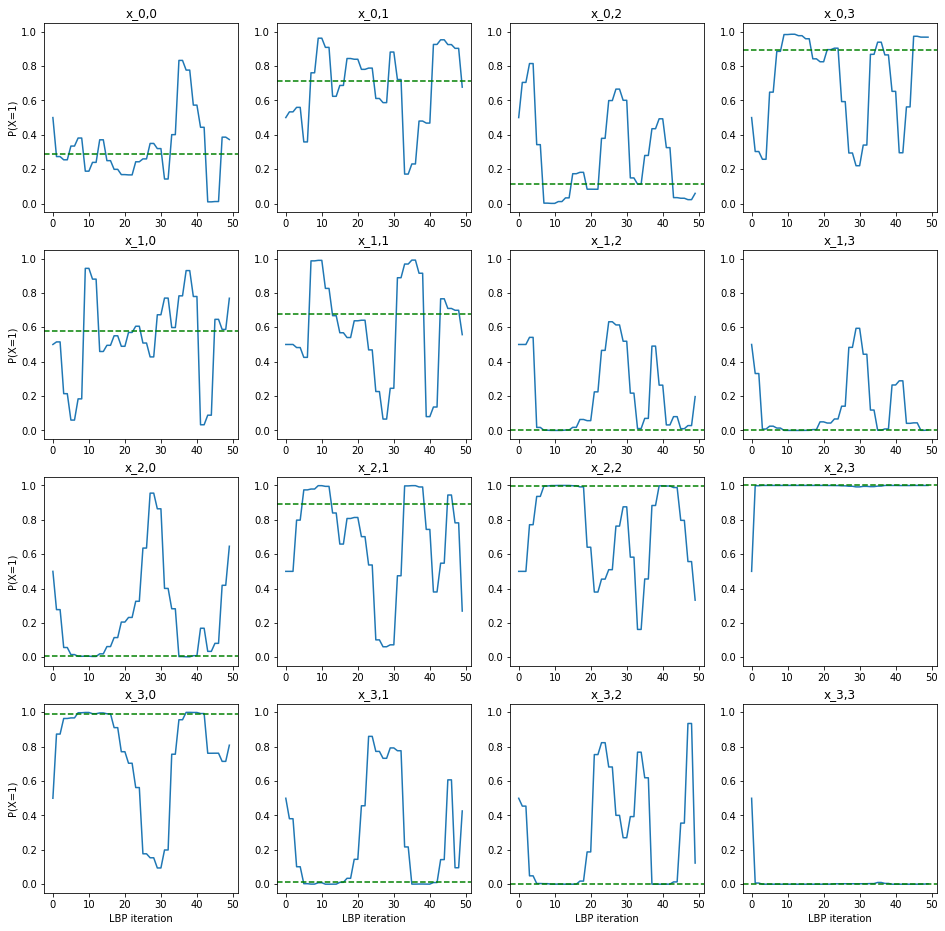

In [24]:
N=int(np.sqrt(len(ising_model_exact_dist)))

fig, ax = plt.subplots(
    nrows=N,
    ncols=N,
    figsize=(16, 16)
)

for i in range(N):
    for j in range(N):
        variable = f'x_{i},{j}'
        ax[i,j].plot(
            [dist[1] for dist in ising_model_lbp_dist[variable]]
        )
        ax[i,j].axhline(
            ising_model_exact_dist[variable][1],
            linestyle='dashed',
            color='green'
        )
        ax[i,j].set_title(variable)
        ax[i,j].set_ylim(-0.05,1.05)
        
        if j == 0:
            ax[i,j].set_ylabel('P(X=1)')
        if i == N-1:
            ax[i,j].set_xlabel('LBP iteration')

plt.show()

# Wnioskowanie dla Boltzmann distribution
Stabilność rozwiązań dla parametryzacji w postaci Boltzmann distribution jest dużo bardziej odporna na dobór parametrów generatora.

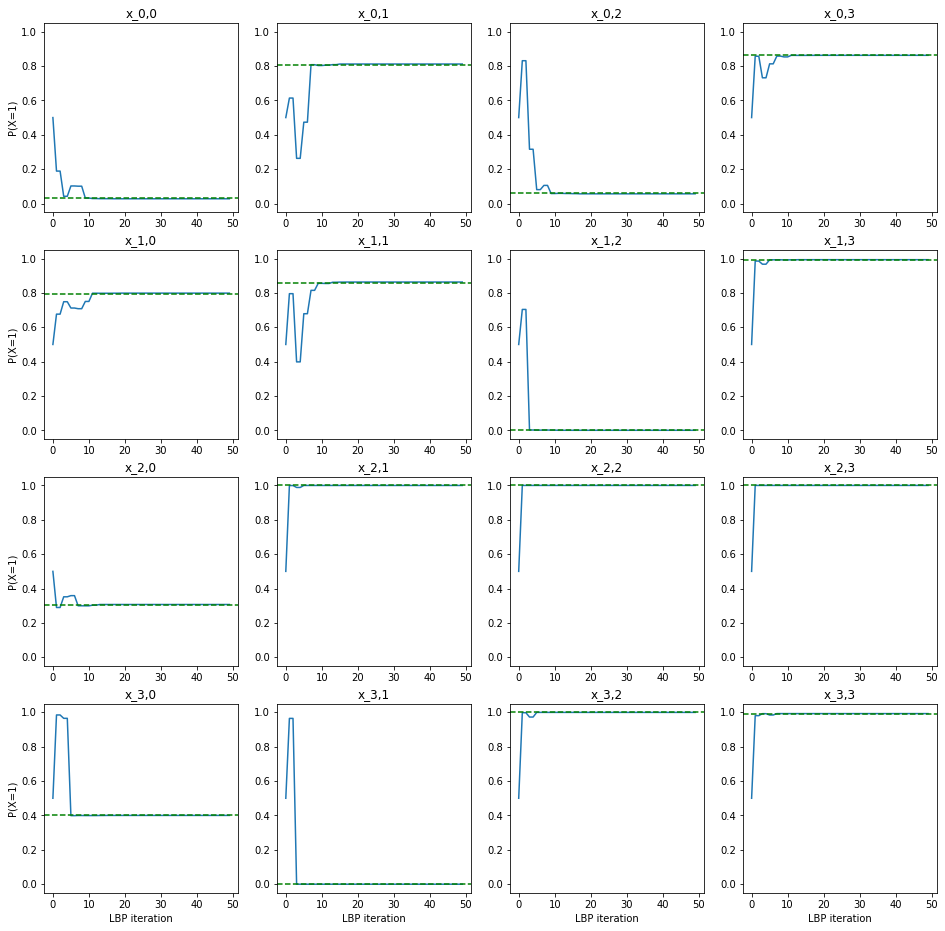

In [25]:
boltzman_distribution = sample_ising_grid(4, C_u=1, C_b=11, ising=False)
boltzman_distribution_exact_dist = dict()
boltzman_distribution_joint_dist = joint_distribution(list(boltzman_distribution.get_factors().values()))
for variable in boltzman_distribution.get_variables():
    dist = factor_marginalization(
        boltzman_distribution_joint_dist,
        [v for v in boltzman_distribution.get_variables() if v != variable]
    ).get_distribution()
    boltzman_distribution_exact_dist[variable] = dist / dist.sum()
lbp = LoopyBeliefPropagation(boltzman_distribution)
it = 50
boltzman_distribution_lbp_dist = defaultdict(list)
for i in range(it):
    for variable in boltzman_distribution.get_variables():
        boltzman_distribution_lbp_dist[variable].append(lbp.belief(variable, i).get_distribution())
        
N=int(np.sqrt(len(boltzman_distribution_exact_dist)))

fig, ax = plt.subplots(
    nrows=N,
    ncols=N,
    figsize=(16, 16)
)

for i in range(N):
    for j in range(N):
        variable = f'x_{i},{j}'
        ax[i,j].plot(
            [dist[1] for dist in boltzman_distribution_lbp_dist[variable]]
        )
        ax[i,j].axhline(
            boltzman_distribution_exact_dist[variable][1],
            linestyle='dashed',
            color='green'
        )
        ax[i,j].set_title(variable)
        ax[i,j].set_ylim(-0.05,1.05)
        
        if j == 0:
            ax[i,j].set_ylabel('P(X=1)')
        if i == N-1:
            ax[i,j].set_xlabel('LBP iteration')

plt.show()

# Zadanie 0
Ustaw zmienną `grading` na `True` w komórce poniżej przed wgraniem ostatecznego rozwiązania.

In [74]:
grading=False

# Zadanie 1 (1 pkt) - Implementacja LBP z dampingiem
Jednym z problemów LBP są zbyt nagłe zmiany przesyłanych wiadomości w kolejnych iteracjach algorytmu. Efektem są rozkłady oscylujące wokół prawidłowych wartości. Próbą rozwiązania tego problemy jest *damping*, czyli przesyłanie nowej wiadomości jako kombinacja wypukła nowej i starej wartości.

1. Zaimplementuj funkcję, która przyjmie dwa czynniki `f1` oraz `f2` (obiekty klasy `factor`), parametr `lmbda` i zwróci kombinację wypukłą czynników tak aby `f1` miał wagę `lmbda`, a `f2` wagę `1-lmbda`. Zwróć uwagę, że użytkownik może podać czynniki określone na różnych zbiorach zmiennych losowych i w takiej sytuacji należy wywołać `Exception`. Ta funkcja przyda Ci się w dalszej części listy.

2. W klasie `LoopyBeliefPropagationDamping` uzupełnij metody `__init__` oraz `_calculate_new_message` (zwróć uwagę, że metoda ma obliczać wiadomość w obu kierunkach krawędzi - tak jak w klasie bazowej) tak aby implementowała LBP z dampingiem, gdzie `lmbda` to parametr dampingu podany przy konstrukcji obiektu. Wykorzystaj funkcję `convex_combination` oraz metodę `__init__` klasy `LoopyBeliefPropagation`.

Żadna inna metoda klasy bazowej niż wyżej wymienione nie powinna zostać zmodyfikowana.

Uwaga: gdy `lmbda=1` to damping zostaje wyłaczony, gdy `lmbda=0` to wiadomości nie są aktualizowane.

In [27]:
def convex_combination(f1: factor, f2: factor, lmbda: float):
    if f1.get_distribution() is None or f2.get_distribution() is None:
        raise ValueError('Factor without distribution passed')
    elif (
        any([v not in f2.get_variables() for v in f1.get_variables()]) or
        any([v not in f1.get_variables() for v in f2.get_variables()])
    ):
        raise ValueError('Variables in factors do not match')
    elif len(f1.get_shape()) == len(f2.get_shape()) and (f1.get_shape() != f2.get_shape()).any():
        raise ValueError('Distributions shapes do not match')
    else:
        combination = []
        for f1_v, f2_v in zip(f1.get_distribution(), f2.get_distribution()):
            combination.append(lmbda * f1_v + (1-lmbda) * f2_v)
        return factor(f1.get_variables(), np.array(combination))
        # TU WPISZ KOD
        #raise NotImplementedError()

In [28]:
from nose.tools import assert_raises

assert_raises(
    ValueError,
    convex_combination,
    factor(['x1', 'x2']),
    factor(['x1', 'x2']),
    0.5
)
assert_raises(
    ValueError,
    convex_combination,
    factor(['x1'], np.array([1, 1])),
    factor(['x2'], np.array([2, 2, 2])),
    0.5
)
assert_raises(
    ValueError,
    convex_combination,
    factor(['x1', 'x2'], np.array([[1, 1], [1, 1]])),
    factor(['x1', 'x2'], np.array([[2, 2, 2], [2, 2, 2]])),
    0.5
)


In [64]:
class LoopyBeliefPropagationDamping(LoopyBeliefPropagation):
    def __init__(self, pgm, lmbda=0.5):
        if type(pgm) is not FactorGraph:
            raise Exception('PGM is not a factor graph')
        if not pgm.is_connected():
            raise Exception('PGM is not connected')
        if len(pgm.get_graph().es) - 1 == len(pgm.get_graph().vs):
            raise Exception('PGM is a tree')
        
        self._t       = 0
        self._msg     = {}
        self._msg_new = {}
        self._pgm     = pgm
        self.lmbda = lmbda
        
        # Initialization of messages
        for edge in self._pgm.get_graph().es:
            start_index, end_index = edge.tuple[0], edge.tuple[1]
            start_name, end_name = (
                self._pgm.get_graph().vs[start_index]['name'],
                self._pgm.get_graph().vs[end_index]['name']
            )
            
            if self._pgm.get_graph().vs[start_index]['is_factor']:
                self._msg[(start_name, end_name)] = self._pgm.get_graph().vs[end_index]['factor_']
            else:
                self._msg[(start_name, end_name)] = factor(
                    [start_name],
                    np.array([1.]*self._pgm.get_graph().vs[start_index]['rank'])
                )
            self._msg[(end_name, start_name)] = self._msg[(start_name, end_name)]
            
            self._msg_new[(start_name, end_name)] = 0
            self._msg_new[(end_name, start_name)] = 0
        
        
    def _calculate_new_message(self, start_index, start_name, end_index, end_name):
        if self._pgm.get_graph().vs[start_index]['is_factor']:
            old = self._msg[(start_name, end_name)]
            self._msg_new[(start_name, end_name)] = self._compute_factor2variable_msg(start_name, end_name)
            self._msg_new[(start_name, end_name)] = convex_combination(self._msg_new[(start_name, end_name)], old, self.lmbda)

            old = self._msg[(end_name, start_name)]
            self._msg_new[(end_name, start_name)] = self._compute_variable2factor_msg(end_name, start_name)
            self._msg_new[(end_name, start_name)] = convex_combination(self._msg_new[(end_name, start_name)], old,self.lmbda)

        else:
            old = self._msg[(start_name, end_name)]
            self._msg_new[(start_name, end_name)] = self._compute_variable2factor_msg(start_name, end_name)
            self._msg_new[(start_name, end_name)] = convex_combination(self._msg_new[(start_name, end_name)], old, self.lmbda)

            old = self._msg[(end_name, start_name)]
            self._msg_new[(end_name, start_name)] = self._compute_factor2variable_msg(end_name, start_name)
            self._msg_new[(end_name, start_name)] = convex_combination(self._msg_new[(end_name, start_name)], old, self.lmbda)

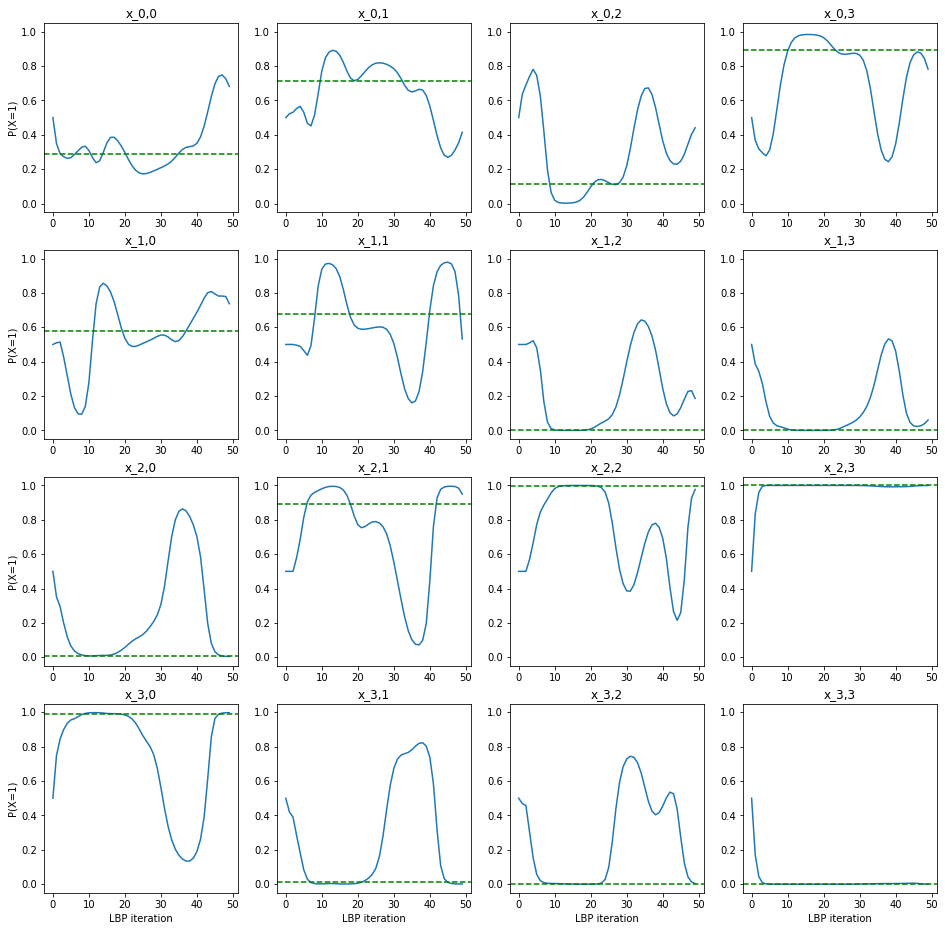

In [65]:
lbp = LoopyBeliefPropagationDamping(ising_model, lmbda=0.8)
it = 50
ising_model_lbp_dist = defaultdict(list)
for i in range(it):
    for variable in ising_model.get_variables():
        ising_model_lbp_dist[variable].append(lbp.belief(variable, i).get_distribution())

N=int(np.sqrt(len(ising_model_exact_dist)))

fig, ax = plt.subplots(
    nrows=N,
    ncols=N,
    figsize=(16, 16)
)

for i in range(N):
    for j in range(N):
        variable = f'x_{i},{j}'
        ax[i,j].plot(
            [dist[1] for dist in ising_model_lbp_dist[variable]]
        )
        ax[i,j].axhline(
            ising_model_exact_dist[variable][1],
            linestyle='dashed',
            color='green'
        )
        ax[i,j].set_title(variable)
        ax[i,j].set_ylim(-0.05,1.05)
        
        if j == 0:
            ax[i,j].set_ylabel('P(X=1)')
        if i == N-1:
            ax[i,j].set_xlabel('LBP iteration')

plt.show()

# Zadanie 2 (2 pkt) - Implementacja asynchronicznego LBP
Rezultat wywołania powyższych komórek wyraźnie pokazuje, że sam damping nie jest w stanie zapewnić stabilnych rezultatów. W tym zadaniu zaimplementujesz asynchroniczne aktualizowanie wiadomości, które powinno poprawić działanie metody.

W dotychczasowej implementacji stan nowych wiadomości był obliczany na podstawie stanów starych wiadomości. To podejście nazywamy synchronicznym. W wielu dziedzinach optymalizacji okazuje się, że podejście asynchroniczne daje lepsze rezultaty. Polega ono na tym aby aktualizować wartości od razu i dokonywać pozostałych aktualizacji w danej iteracji na podstawie nowych wartości (tam gdzie dostępne) oraz starych (tam gdzie nowe jeszcze niedostępne).

W podejściu asynchronicznym pojawia się problem ustalenia kolejności wykonywania aktualizacji. Oto trzy z możliwych podejść:
- losowa kolejność, stała we wszystkich iteracjach
- kolejność losowana w każdej iteracji
- arbitralna kolejność zadana przez użytkownika

W tym zadaniu zaimplementujesz te trzy podejścia w klasie `AsynchronousLoopyBeliefPropagationDamping`. Jednocześnie zachowaj funkcjonalność damping.

1. Uzupełnij funkcję `__init__` tak aby zależnie od wartości parametru `fixed_order` realizowała trzy podejścia:
   - `fixed_order == True` - losowa kolejność, stała we wszystkich iteracjach
   - `fixed_order == False` - kolejność losowana w każdej iteracji
   - `fixed_order` listą krawędzi - arbitralna kolejność zadana przez użytkownika (UWAGA: sprawdź, czy lista krawędzi odpowiada modelowi; w przeciwnym wypadku wywołaj `Exception`)
   W celu losowania kolejność wykorzystaj generator `rng` zdefiniowany wcześniej w tym zeszycie. Przypisz wartość zmiennej `self.fixed_order`.
   
2. Uzupełnij funkcję `_calculate_new_message` tak aby aktualizowała wiadomość wyłącznie w zdanym kierunku (inaczej niż dotychczas) i pozwalała na wykorzystanie dampingu.
  
Żadna inna metoda klasy bazowej nie powinna zostać nadpisana.

In [80]:
class AsynchronousLoopyBeliefPropagationDamping(LoopyBeliefPropagation):
    def __init__(self, pgm, lmbda=0.5, fixed_order=False):
        if type(pgm) is not FactorGraph:
            raise Exception('PGM is not a factor graph')
        if not pgm.is_connected():
            raise Exception('PGM is not connected')
        if len(pgm.get_graph().es) - 1 == len(pgm.get_graph().vs):
            raise Exception('PGM is a tree')
        
        self._t       = 0
        self._msg     = {}
        self._pgm     = pgm
        
        # Initialization of messages
        for edge in self._pgm.get_graph().es:
            start_index, end_index = edge.tuple[0], edge.tuple[1]
            start_name, end_name = (
                self._pgm.get_graph().vs[start_index]['name'],
                self._pgm.get_graph().vs[end_index]['name']
            )
            
            if self._pgm.get_graph().vs[start_index]['is_factor']:
                self._msg[(start_name, end_name)] = self._pgm.get_graph().vs[end_index]['factor_']
            else:
                self._msg[(start_name, end_name)] = factor(
                    [start_name],
                    np.array([1.]*self._pgm.get_graph().vs[start_index]['rank'])
                )
            self._msg[(end_name, start_name)] = self._msg[(start_name, end_name)]

        self.lmbda = lmbda
        
        self._edges = list(chain(*[
            (edge.tuple, tuple(reversed(edge.tuple)))
            for edge in self._pgm.get_graph().es
        ]))
        self.fixed_order = fixed_order
        if fixed_order is True:
             rng.shuffle(self._edges)
        elif  fixed_order is False:
             rng.shuffle(self._edges)
        else:
            if sorted(self.fixed_order) == sorted(self._edges):
                self._edges = self.fixed_order
            else:
                raise Exception('Incorrect edge list')
            
        
        # TU WPISZ KOD
        #raise NotImplementedError()
                
    def _calculate_new_message(self, start_index, start_name, end_index, end_name):
        if self._pgm.get_graph().vs[start_index]['is_factor']:
            old = self._msg[(start_name, end_name)]
            self._msg[(start_name, end_name)] = self._compute_factor2variable_msg(start_name, end_name)
            self._msg[(start_name, end_name)] = convex_combination(self._msg[(start_name, end_name)], old, self.lmbda)
        else:
            old = self._msg[(start_name, end_name)]
            self._msg[(start_name, end_name)] = self._compute_variable2factor_msg(start_name, end_name)
            self._msg[(start_name, end_name)] = convex_combination(self._msg[(start_name, end_name)], old, self.lmbda)
        
    def _loop(self, num_iter):
        # Message updating
        while self._t < num_iter:
            for edge in self._edges:
                start_index, end_index = edge
                start_name, end_name   = (
                    self._pgm.get_graph().vs[start_index]['name'],
                    self._pgm.get_graph().vs[end_index]['name']
                )

                self._calculate_new_message(start_index, start_name, end_index, end_name)
            self._t += 1
            if not self.fixed_order:
                rng.shuffle(self._edges)

### Losowa kolejność w każdej iteracji

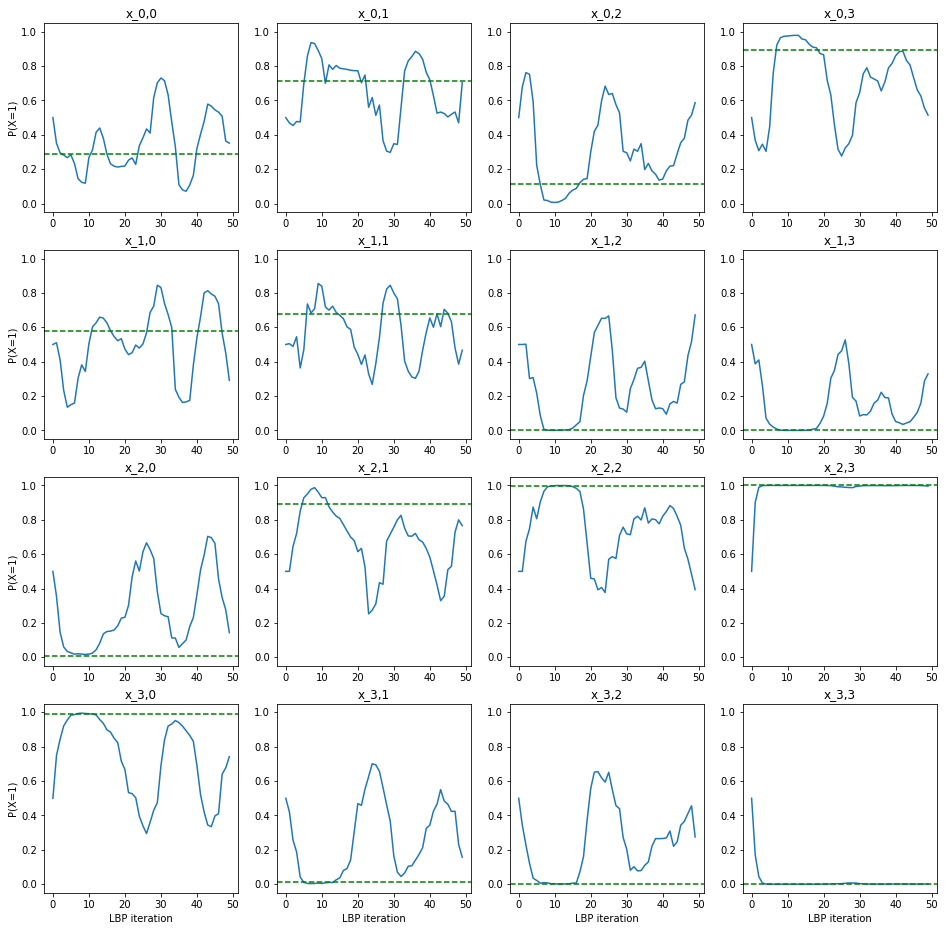

In [81]:
lbp = AsynchronousLoopyBeliefPropagationDamping(
    ising_model,
    lmbda=0.8,
    fixed_order=False
)
it = 50
ising_model_lbp_dist = defaultdict(list)
for i in range(it):
    for variable in ising_model.get_variables():
        ising_model_lbp_dist[variable].append(lbp.belief(variable, i).get_distribution())

N=int(np.sqrt(len(ising_model_exact_dist)))

fig, ax = plt.subplots(
    nrows=N,
    ncols=N,
    figsize=(16, 16)
)

for i in range(N):
    for j in range(N):
        variable = f'x_{i},{j}'
        ax[i,j].plot(
            [dist[1] for dist in ising_model_lbp_dist[variable]]
        )
        ax[i,j].axhline(
            ising_model_exact_dist[variable][1],
            linestyle='dashed',
            color='green'
        )
        ax[i,j].set_title(variable)
        ax[i,j].set_ylim(-0.05,1.05)
        
        if j == 0:
            ax[i,j].set_ylabel('P(X=1)')
        if i == N-1:
            ax[i,j].set_xlabel('LBP iteration')

plt.show()

### Ta sama losowa kolejność w każdej iteracji

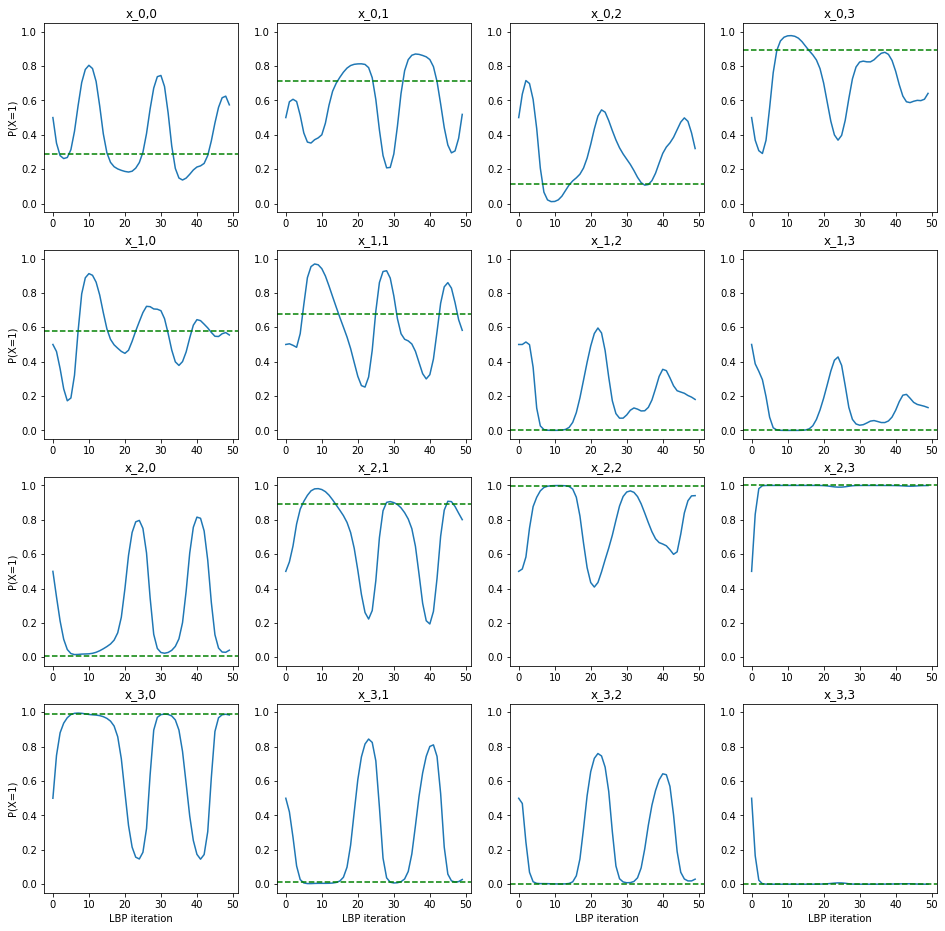

In [82]:
lbp = AsynchronousLoopyBeliefPropagationDamping(
    ising_model,
    lmbda=0.8,
    fixed_order=True
)
it = 50
ising_model_lbp_dist = defaultdict(list)
for i in range(it):
    for variable in ising_model.get_variables():
        ising_model_lbp_dist[variable].append(lbp.belief(variable, i).get_distribution())

N=int(np.sqrt(len(ising_model_exact_dist)))

fig, ax = plt.subplots(
    nrows=N,
    ncols=N,
    figsize=(16, 16)
)

for i in range(N):
    for j in range(N):
        variable = f'x_{i},{j}'
        ax[i,j].plot(
            [dist[1] for dist in ising_model_lbp_dist[variable]]
        )
        ax[i,j].axhline(
            ising_model_exact_dist[variable][1],
            linestyle='dashed',
            color='green'
        )
        ax[i,j].set_title(variable)
        ax[i,j].set_ylim(-0.05,1.05)
        
        if j == 0:
            ax[i,j].set_ylabel('P(X=1)')
        if i == N-1:
            ax[i,j].set_xlabel('LBP iteration')

plt.show()

### Domyślna kolejność krawędzi w grafie

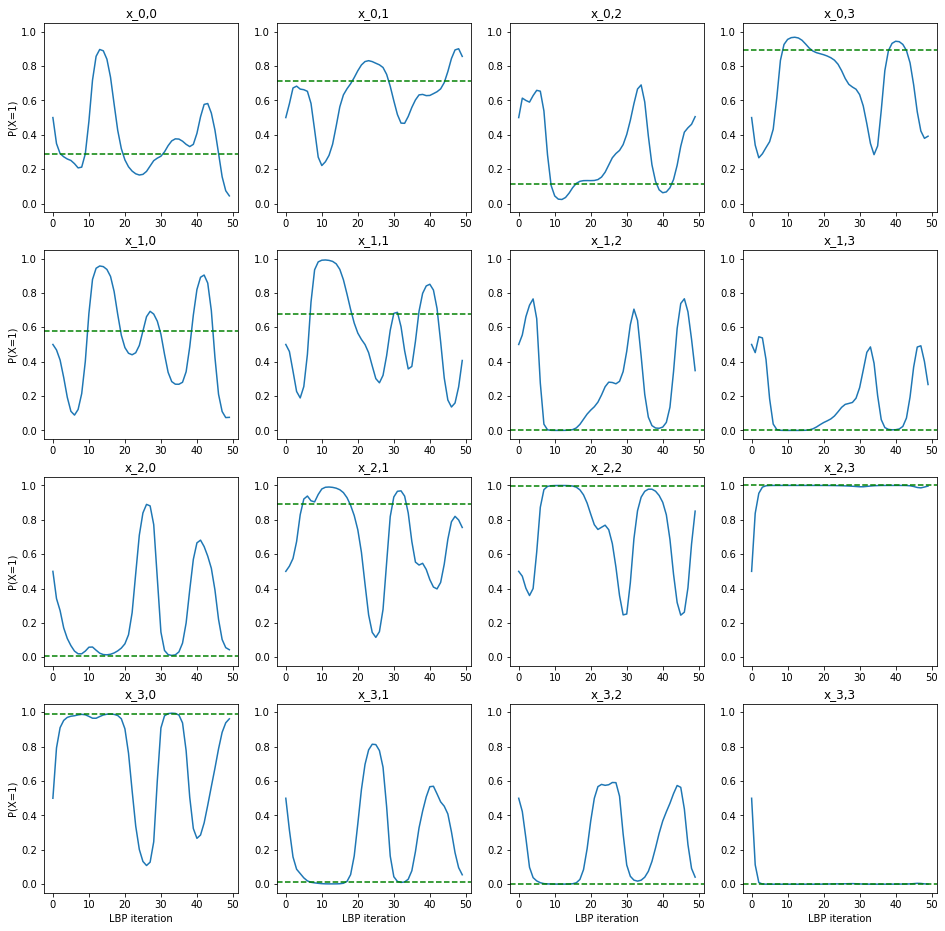

In [83]:
lbp = AsynchronousLoopyBeliefPropagationDamping(
    ising_model,
    lmbda=0.8,
    fixed_order=list(chain(*[
        (edge.tuple, tuple(reversed(edge.tuple)))
        for edge in ising_model.get_graph().es
    ]))
)
it = 50
ising_model_lbp_dist = defaultdict(list)
for i in range(it):
    for variable in ising_model.get_variables():
        ising_model_lbp_dist[variable].append(lbp.belief(variable, i).get_distribution())

N=int(np.sqrt(len(ising_model_exact_dist)))

fig, ax = plt.subplots(
    nrows=N,
    ncols=N,
    figsize=(16, 16)
)

for i in range(N):
    for j in range(N):
        variable = f'x_{i},{j}'
        ax[i,j].plot(
            [dist[1] for dist in ising_model_lbp_dist[variable]]
        )
        ax[i,j].axhline(
            ising_model_exact_dist[variable][1],
            linestyle='dashed',
            color='green'
        )
        ax[i,j].set_title(variable)
        ax[i,j].set_ylim(-0.05,1.05)
        
        if j == 0:
            ax[i,j].set_ylabel('P(X=1)')
        if i == N-1:
            ax[i,j].set_xlabel('LBP iteration')

plt.show()

# Zadanie 3 (2 pkt) - Residual Belief Propagation
Publikacja - [Elidan, G., McGraw, I., & Koller, D. (2006). Residual belief propagation: Informed scheduling for asynchronous message passing. Proceedings of the 22nd Conference on Uncertainty in Artificial Intelligence, UAI 2006, 165–173.](https://ai.stanford.edu/~koller/Papers/Elidan+al:UAI06.pdf)

Autorzy poza wprowadzeniem i ewaluacją metody Residual Belief Propagation poświęcają dużo tekstu na dyskusję o ocenie zbieżności Loopy Belief Propagation dla modeli probabilistycznych.

To zadanie polega na implementacji metody *Residual Belief Propagation* zaproponowanej w powyższej publikacji. Polega ona na dynamicznym harmonogramowaniu kolejności aktualizacji w asynchroniczym LBP tak aby wiadomości jak najszybciej zbiegały do punktu stałego. Chcemy najpierw aktulizować wiadomości najbardziej oddalone od swojego optimum. Ponieważ punkt stały nie jest znany (szukamy go), wyprowadzone zostaje dolne ograniczenie na rezyduum odległości. Dla nowej wiadomości $m_{st}$ po $k$ iteracjach algorytmu rezyduum zdefiniowane jest jako:
$$ r(s,t,k) = \max_i \left| \log \frac{m_{st}(i)}{m^k_{st}(i)} \right|,$$
gdzie $m^k_{st}$ to ostatnia wysłana wiadomość na tej krawędzi, a maksimum liczone jest po nośniku wiadomości.

W każdej iteracji algorytmu sukcesywnie aktualizuje się kolejne wiadomości o największym rezyduum. Po aktualizacji jednej wiadomości wszystkie pozostale muszą zostać zreewaluowane - podejście asynchroniczne. Oznacza to, że każda iteracja polega na obliczeniu $n!$ wiadomości, gdzie $n$ to liczba wiadomości do wysłania, czyli dwukrotność liczby krawędzi w grafie.

1. Zaimplementuje metode `_get_residual` zgodnie z powyższym wzorem.
2. Uzupełnij implementację funkcji `_loop` tak by w każdej iteracji dokonywała aktualizacji wiadomości zgodną z kolejność wynikającą z wielkości rezyduów. Zwróć uwagę, że rezyduum ma być obliczane bez wykorzystania dampingu, natomiast aktualizacje z dampingiem.

Żadna inne metoda klasy bazowej nie powinna być nadpisana.

In [72]:
class ResidualLoopyBeliefPropagationDamping(LoopyBeliefPropagation):
    def __init__(self, pgm, lmbda=0.5):
        if type(pgm) is not FactorGraph:
            raise Exception('PGM is not a factor graph')
        if not pgm.is_connected():
            raise Exception('PGM is not connected')
        if len(pgm.get_graph().es) - 1 == len(pgm.get_graph().vs):
            raise Exception('PGM is a tree')
        
        self._t       = 0
        self._msg     = {}
        self._pgm     = pgm
        
        # Initialization of messages
        for edge in self._pgm.get_graph().es:
            start_index, end_index = edge.tuple[0], edge.tuple[1]
            start_name, end_name = (
                self._pgm.get_graph().vs[start_index]['name'],
                self._pgm.get_graph().vs[end_index]['name']
            )
            
            if self._pgm.get_graph().vs[start_index]['is_factor']:
                self._msg[(start_name, end_name)] = self._pgm.get_graph().vs[end_index]['factor_']
            else:
                self._msg[(start_name, end_name)] = factor(
                    [start_name],
                    np.array([1.]*self._pgm.get_graph().vs[start_index]['rank'])
                )
            self._msg[(end_name, start_name)] = self._msg[(start_name, end_name)]

        self.lmbda = lmbda
        
        self._edges = list(chain(*[
            (edge.tuple, tuple(reversed(edge.tuple)))
            for edge in self._pgm.get_graph().es
        ]))
        
    def _get_residual(self, key, msg_new, msg_old):
        return abs(np.log(msg_new[key].get_distribution()/msg_old[key].get_distribution()))
    
    def _calculate_new_message(self, start_index, start_name, end_index, end_name):
        if self._pgm.get_graph().vs[start_index]['is_factor']:
            return self._compute_factor2variable_msg(start_name, end_name)
        else:
            return self._compute_variable2factor_msg(start_name, end_name)
        
    def _loop(self, num_iter):
        # Message updating
        while self._t < num_iter:
            print(self._t)
            edge_queue = set(self._edges)
            while len(edge_queue) > 0:
                _msg_new = dict()
                _msg_residual = dict()
                highest_residual_edge = None
                for edge in edge_queue:
                    start_index, end_index = edge
                    start_name, end_name   = (
                        self._pgm.get_graph().vs[start_index]['name'],
                        self._pgm.get_graph().vs[end_index]['name']
                    )
                    _msg_new[(start_name, end_name)] =  self._calculate_new_message(start_index, start_name, end_index, end_name)
                    _msg_residual[(start_name, end_name)] = self._get_residual((start_name, end_name), _msg_new, self._msg)
                
            
                curr_max = -10
                for key, value in _msg_residual.items():
                    if max(value) > curr_max:
                        curr_max = max(value)
                        highest_residual_edge = key

                self._msg[highest_residual_edge] = convex_combination(_msg_new[highest_residual_edge], self._msg[highest_residual_edge], self.lmbda)
                remove_edge = tuple(map(
                    lambda x: self._pgm.get_graph().vs.find(name=x).index,
                    highest_residual_edge
                ))
                edge_queue.remove(remove_edge)
                
            self._t += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


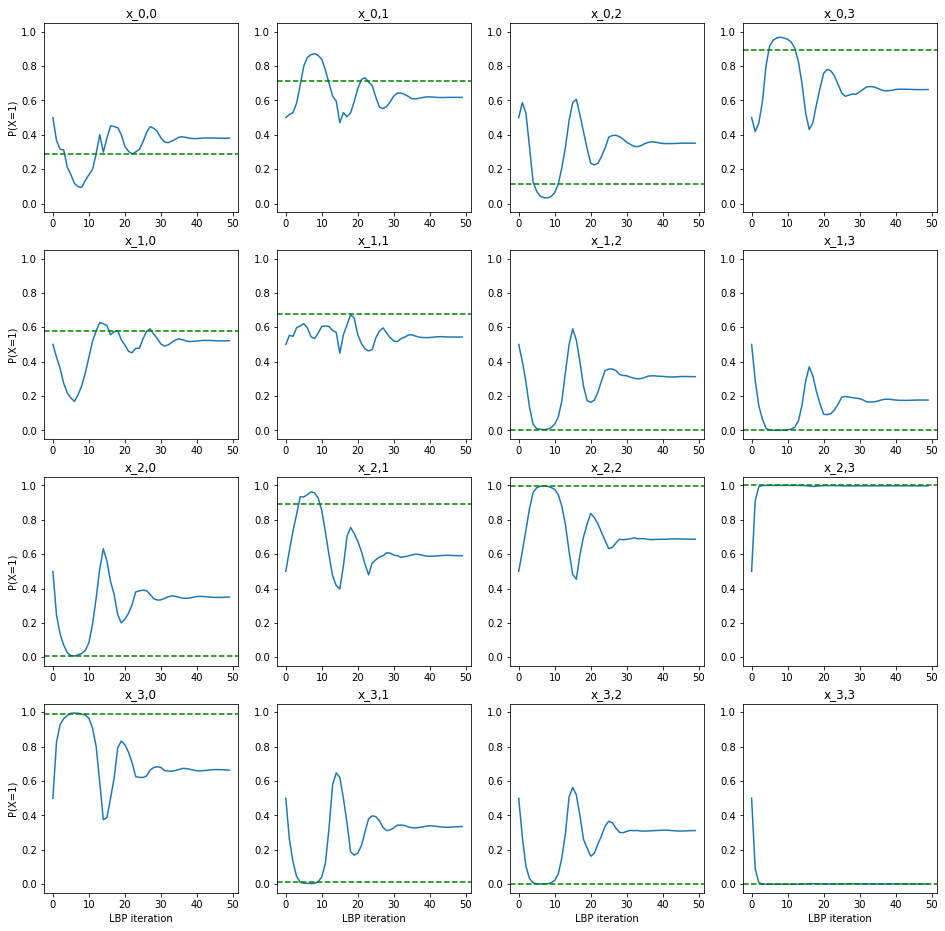

In [73]:
lbp = ResidualLoopyBeliefPropagationDamping(
    ising_model,
    lmbda=0.8,
)
it = 50
ising_model_lbp_dist = defaultdict(list)
for i in range(it):
    for variable in ising_model.get_variables():
        ising_model_lbp_dist[variable].append(lbp.belief(variable, i).get_distribution())

N=int(np.sqrt(len(ising_model_exact_dist)))

fig, ax = plt.subplots(
    nrows=N,
    ncols=N,
    figsize=(16, 16)
)

for i in range(N):
    for j in range(N):
        variable = f'x_{i},{j}'
        ax[i,j].plot(
            [dist[1] for dist in ising_model_lbp_dist[variable]]
        )
        ax[i,j].axhline(
            ising_model_exact_dist[variable][1],
            linestyle='dashed',
            color='green'
        )
        ax[i,j].set_title(variable)
        ax[i,j].set_ylim(-0.05,1.05)
        
        if j == 0:
            ax[i,j].set_ylabel('P(X=1)')
        if i == N-1:
            ax[i,j].set_xlabel('LBP iteration')

plt.show()

RLBP na innym modelu probabilistycznym

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


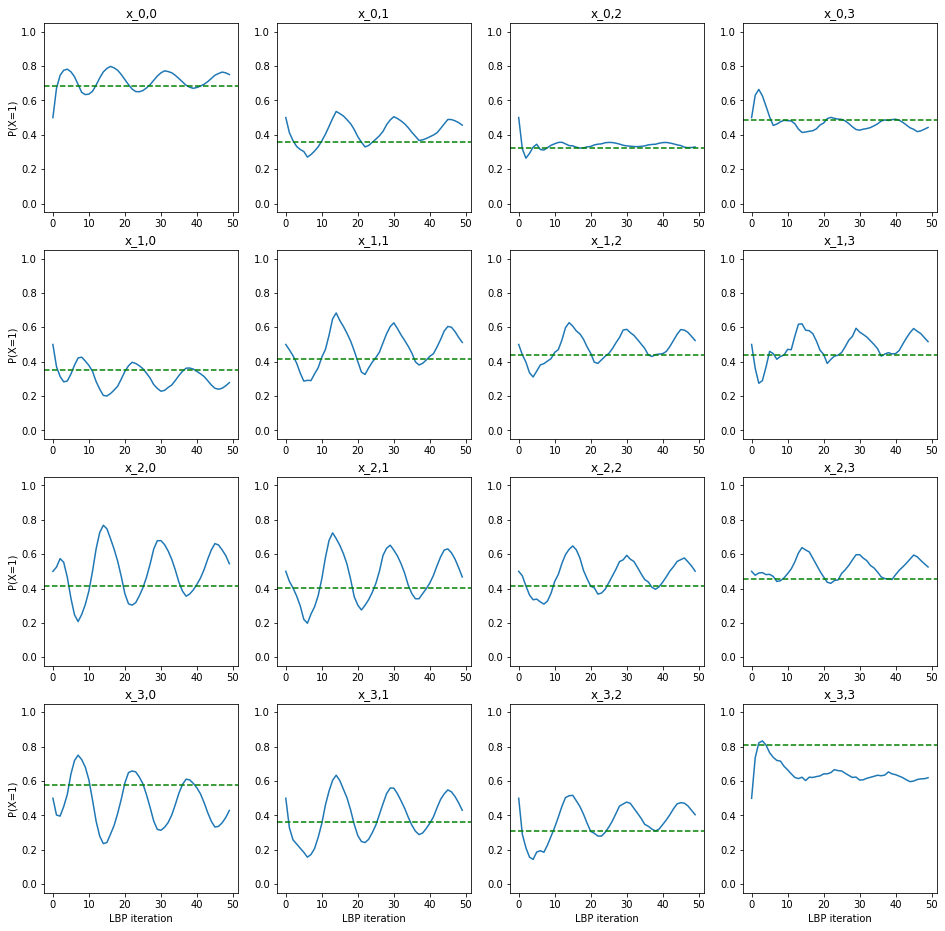

In [75]:
if not grading:
    rng = default_rng(2023)
    ising_model_2 = sample_ising_grid(4, C_u=1, C_b=2, ising=True)
    ising_model_2_exact_dist = dict()
    ising_model_2_joint_dist = joint_distribution(list(ising_model_2.get_factors().values()))
    for variable in ising_model_2.get_variables():
        dist = factor_marginalization(
            ising_model_2_joint_dist,
            [v for v in ising_model_2.get_variables() if v != variable]
        ).get_distribution()
        ising_model_2_exact_dist[variable] = dist / dist.sum()

    lbp = ResidualLoopyBeliefPropagationDamping(
        ising_model_2,
        lmbda=0.8,
    )
    it = 50
    ising_model_2_lbp_dist = defaultdict(list)
    for i in range(it):
        for variable in ising_model_2.get_variables():
            ising_model_2_lbp_dist[variable].append(lbp.belief(variable, i).get_distribution())

    N=int(np.sqrt(len(ising_model_2_exact_dist)))

    fig, ax = plt.subplots(
        nrows=N,
        ncols=N,
        figsize=(16, 16)
    )

    for i in range(N):
        for j in range(N):
            variable = f'x_{i},{j}'
            ax[i,j].plot(
                [dist[1] for dist in ising_model_2_lbp_dist[variable]]
            )
            ax[i,j].axhline(
                ising_model_2_exact_dist[variable][1],
                linestyle='dashed',
                color='green'
            )
            ax[i,j].set_title(variable)
            ax[i,j].set_ylim(-0.05,1.05)

            if j == 0:
                ax[i,j].set_ylabel('P(X=1)')
            if i == N-1:
                ax[i,j].set_xlabel('LBP iteration')

    plt.show()

# Appendix

### Dokładne, wydajne wnioskowanie dla planarnych modeli
Publikacja - [Schraudolph, N. N., & Kamenetsky, D. (2009). Efficient exact inference in planar ising models. Advances in Neural Information Processing Systems 21 - Proceedings of the 2008 Conference, 1, 1417–1424.](https://papers.nips.cc/paper/2008/file/816b112c6105b3ebd537828a39af4818-Paper.pdf)

Implementacja w C++ - https://nic.schraudolph.org/isinf/

Ising Model jest modelem o grafie planarnym.

### Normalizacja w Belief Propadation
W powyżej zaimplementowanych algorytmach dokonywaliśmy normalizacji każdej z wiadomości od czynnika do zmiennej tak by była dyskretnym rozkładem prawdopobieństwa (suma wartości równa 1). Nie jest to jedyny możliwy sposób normalizacji. Zagadnienie to zostało omówione w tym raporcie - [Martin, V., Lasgouttes, J.-M., & Furtlehner, C. (2011). The Role of Normalization in the Belief Propagation Algorithm. http://arxiv.org/abs/1101.4170](https://pages.saclay.inria.fr/cyril.furtlehner/files/RR-7514.pdf)